In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Change the current working directory to MyDrive/DLPJ
os.chdir('/content/drive/MyDrive/DLPJ/src')

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://download.pytorch.org/whl/cu118
Current working directory: /content/drive/MyDrive/DLPJ/src


In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
from msstud_spiel_shim import MsStudSpielGame
from qlearning_tabular import TabularQAgent
from dqn_agent import DQNAgent
from dueling_dqn_agent import DuelingDQNAgent
from tq2 import TabularQAgentV2
from ppo_agent import PPOAgent
from scipy.stats import ttest_ind
# If you have a distributional DQN implementation, import it here:
try:
    from distributional_dqn_agent import DistributionalDQNAgent
    HAS_DIST_DQN = True
except ImportError:
    HAS_DIST_DQN = False

MODELS = [
    ("Tabular Q-Learning", TabularQAgent, {"alpha":0.2, "gamma":1.0, "epsilon":0.95}),
    ("Tabular Q-Learning V2", TabularQAgentV2, {"alpha":0.2, "gamma":1.0, "epsilon":0.95}),
    ("DQN (default)", DQNAgent, {"lr":5e-4, "gamma":1.0, "epsilon":0.95, "batch_size":128}),
    ("DQN (low lr)", DQNAgent, {"lr":1e-4, "gamma":1.0, "epsilon":0.95, "batch_size":128}),
    ("DQN (high batch)", DQNAgent, {"lr":5e-4, "gamma":1.0, "epsilon":0.95, "batch_size":256}),
    ("Dueling DQN (default)", DuelingDQNAgent, {"lr":5e-4, "gamma":1.0, "epsilon":0.95, "batch_size":128}),
    ("Dueling DQN (low lr)", DuelingDQNAgent, {"lr":1e-4, "gamma":1.0, "epsilon":0.95, "batch_size":128}),
    ("Dueling DQN (high batch)", DuelingDQNAgent, {"lr":5e-4, "gamma":1.0, "epsilon":0.95, "batch_size":256}),
    ("PPO", PPOAgent, {"lr":5e-4, "gamma":1.0, "clip":0.2}),
]

# temporary for replacement
#MODELS = []

if HAS_DIST_DQN:
    MODELS.append(("Distributional DQN", DistributionalDQNAgent, {"lr":5e-4, "gamma":1.0, "epsilon":0.2, "batch_size":128}))

TRAIN_EPISODES = 100000
TEST_EPISODES = 10000
FRIENDS_MIN = 0
FRIENDS_MAX = 4
SEED_TRAIN = 42
SEED_TEST = 12345

# Configurable parameters
import argparse
parser = argparse.ArgumentParser(description="Train and test models with different friends settings and DQN variations.")
parser.add_argument('--train_episodes', type=int, default=TRAIN_EPISODES)
parser.add_argument('--test_episodes', type=int, default=TEST_EPISODES)
parser.add_argument('--friends_min', type=int, default=FRIENDS_MIN)
parser.add_argument('--friends_max', type=int, default=FRIENDS_MAX)
args = parser.parse_args([]) # Modified this line
TRAIN_EPISODES = args.train_episodes
TEST_EPISODES = args.test_episodes
FRIENDS_RANGE = list(range(args.friends_min, args.friends_max+1))

results = {}

for friends in FRIENDS_RANGE:
    results[friends] = {}
    for name, AgentClass, params in MODELS:
        print(f"Training {name} with {friends} friends...")
        train_game = MsStudSpielGame(ante=1, seed=SEED_TRAIN, friends=friends)
        if name.startswith("Tabular Q-Learning V2"):
            agent = AgentClass(train_game)
            agent.train(episodes=TRAIN_EPISODES)
        else:
            agent = AgentClass(train_game, **params)
            if hasattr(agent, 'train'):
                agent.train(episodes=TRAIN_EPISODES)
        # Test with fixed seed
        test_game = MsStudSpielGame(ante=1, seed=SEED_TEST, friends=friends)
        returns = []
        for _ in range(TEST_EPISODES):
            state = test_game.new_initial_state()
            while not state.is_terminal():
                action = agent.policy(state)
                state.apply_action(action)
            returns.append(state.returns()[0])
        avg_ev = np.mean(returns)
        std_ev = np.std(returns)
        results[friends][name] = {
            "returns": returns,
            "avg_ev": avg_ev,
            "std_ev": std_ev,
        }
        print(f"{name} | Friends: {friends} | Avg EV: {avg_ev:.4f} | Std: {std_ev:.4f}")


Training Tabular Q-Learning with 0 friends...
Training tabular Q-learning for 100000 episodes...
Episode 10000, epsilon: 0.1285, Q-table size: 19396, Avg return: -3.360
Episode 20000, epsilon: 0.0174, Q-table size: 36826, Avg return: -3.150
Episode 30000, epsilon: 0.0100, Q-table size: 54171, Avg return: -2.960
Episode 40000, epsilon: 0.0100, Q-table size: 71455, Avg return: -2.780
Episode 50000, epsilon: 0.0100, Q-table size: 88627, Avg return: -4.140
Episode 60000, epsilon: 0.0100, Q-table size: 105779, Avg return: -2.760
Episode 70000, epsilon: 0.0100, Q-table size: 122834, Avg return: -3.090
Episode 80000, epsilon: 0.0100, Q-table size: 139819, Avg return: -2.520
Episode 90000, epsilon: 0.0100, Q-table size: 156698, Avg return: -2.540
Tabular Q-Learning | Friends: 0 | Avg EV: -2.9244 | Std: 7.1740
Training Tabular Q-Learning V2 with 0 friends...
Tabular Q-Learning V2 | Friends: 0 | Avg EV: -1.0000 | Std: 0.0000
Training DQN (default) with 0 friends...
Using GPU: NVIDIA A100-SXM4-40

/tmp/ipython-input-1985270816.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  self.colors_map = plt.cm.get_cmap('tab10', len(models)) # Colormap for distinct colors


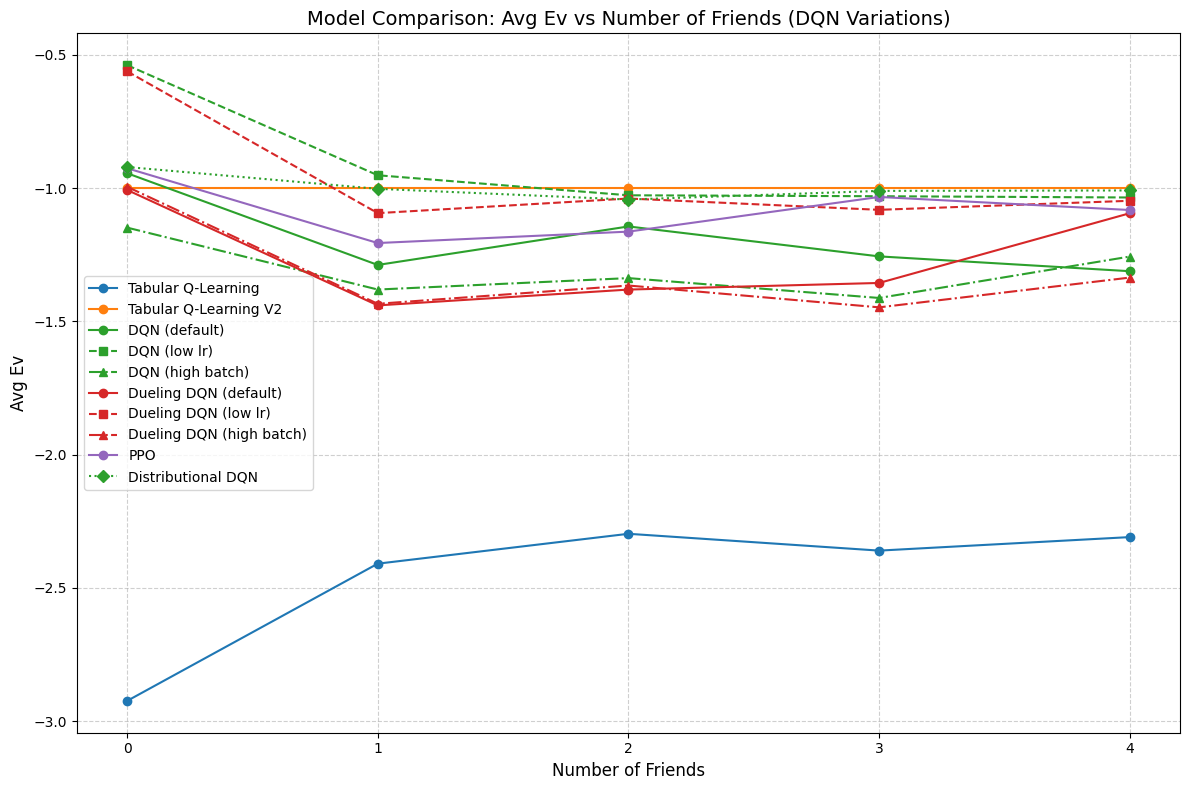

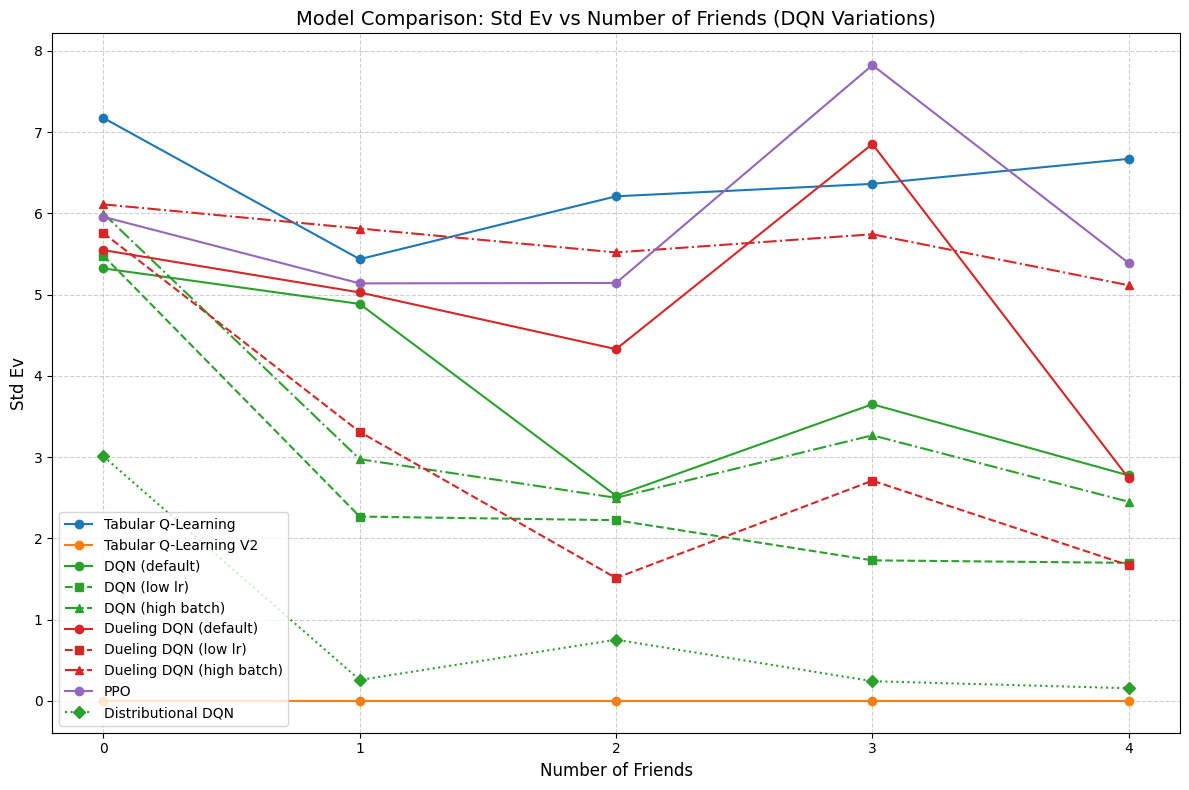

Analysis complete. Graphs saved as PNG files.
Performance results (without raw returns) saved to performance_results.json


In [ ]:
# Class to manage consistent plotting styles across models and their variations
class ModelPlotStyler:
    def __init__(self, models):
        self.colors_map = plt.cm.get_cmap('tab10', len(models)) # Colormap for distinct colors
        self.linestyles = ['-', '--', '-.', ':']
        self.markers = ['o', 's', '^', 'D'] # Markers for variations
        self.reset() # Initialize state

    def reset(self):
        """Resets the style tracking for a new plot."""
        self.model_family_style_idx = {}
        self.model_family_colors = {}
        self.current_color_idx = 0

    def get_style(self, model_name):
        """Returns color, linestyle, and marker for a given model name."""
        # Determine the base model family
        if "Tabular Q-Learning V2" in model_name:
            base_name = "Tabular Q-Learning V2"
        elif "Tabular Q-Learning" in model_name:
            base_name = "Tabular Q-Learning"
        elif "DQN" in model_name and "Dueling" not in model_name:
            base_name = "DQN"
        elif "Dueling DQN" in model_name:
            base_name = "Dueling DQN"
        elif "PPO" in model_name:
            base_name = "PPO"
        elif "Distributional DQN" in model_name:
            base_name = "Distributional DQN"
        else:
            base_name = model_name

        # Assign a color to the base model family if not already assigned
        if base_name not in self.model_family_colors:
            self.model_family_colors[base_name] = self.colors_map(self.current_color_idx)
            self.current_color_idx += 1
            self.model_family_style_idx[base_name] = 0 # Initialize style index for this family

        # Get the color for the current model
        color = self.model_family_colors[base_name]

        # Get the linestyle and marker for the current variation
        style_idx = self.model_family_style_idx[base_name]
        linestyle = self.linestyles[style_idx % len(self.linestyles)]
        marker = self.markers[style_idx % len(self.markers)]
        self.model_family_style_idx[base_name] += 1 # Increment for the next variation

        return color, linestyle, marker

# Instantiate the styler once
styler = ModelPlotStyler(MODELS)

# Plotting
for metric in ["avg_ev", "std_ev"]:
    plt.figure(figsize=(12, 8)) # Increased figure size for better readability
    styler.reset() # Reset style tracking for the new plot

    for name, _, _ in MODELS:
        color, linestyle, marker = styler.get_style(name)
        ys = [results[f][name][metric] for f in FRIENDS_RANGE]
        plt.plot(FRIENDS_RANGE, ys, marker=marker, label=name, color=color, linestyle=linestyle)

    plt.xlabel("Number of Friends", fontsize=12)
    plt.ylabel(metric.replace('_', ' ').title(), fontsize=12) # Improve label readability
    plt.title(f"Model Comparison: {metric.replace('_', ' ').title()} vs Number of Friends (DQN Variations)", fontsize=14)
    plt.legend() # Adjust legend position
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(FRIENDS_RANGE) # Ensure x-axis ticks are only for FRIENDS_RANGE values
    plt.tight_layout()
    plt.savefig(f"model_{metric}_vs_friends_dqn_variations.png")
    plt.show()

print("Analysis complete. Graphs saved as PNG files.")

# Custom JSON encoder to handle NumPy types
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

# Create a copy of the results to modify for saving
results_to_save = {} # Create a new dictionary to store filtered results
for friends, models_data in results.items():
    results_to_save[friends] = {}
    for model_name, data in models_data.items():
        filtered_data = {k: v for k, v in data.items() if k != 'returns'}
        results_to_save[friends][model_name] = filtered_data

# Save the filtered results dictionary to a JSON file
results_file_path = 'performance_results.json'
with open(results_file_path, 'w') as f:
    json.dump(results_to_save, f, indent=4, cls=NpEncoder)

print(f"Performance results (without raw returns) saved to {results_file_path}")

In [1]:
# Statistical tests and graphs

print("\n===== MODEL vs MODEL statistical tests (per #friends) =====\n")

model_vs_model_stats = {}
for friends in FRIENDS_RANGE:
    print(f"\n--- Friends = {friends} ---")
    model_vs_model_stats[friends] = {}

    model_names = list(results[friends].keys())
    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            m1, m2 = model_names[i], model_names[j]
            r1 = results[friends][m1]["returns"]
            r2 = results[friends][m2]["returns"]
            stat, pval = ttest_ind(r1, r2, equal_var=False)

            print(f"{m1} vs {m2}: p = {pval:.4e}")

            model_vs_model_stats[friends][f"{m1} vs {m2}"] = {
                "p_value": pval,
                "mean_m1": float(np.mean(r1)),
                "mean_m2": float(np.mean(r2)),
                "diff": float(np.mean(r2) - np.mean(r1)),
            }

print("\n\n===== FRIENDS EFFECT statistical tests (EV(k) vs EV(k-1)) =====\n")

friends_effect_stats = {}

def cohens_d(x, y):
    s1, s2 = np.var(x, ddof=1), np.var(y, ddof=1)
    n1, n2 = len(x), len(y)
    s_p = np.sqrt(((n1 - 1)*s1 + (n2 - 1)*s2) / (n1 + n2 - 2))
    return (np.mean(y) - np.mean(x)) / s_p

def ci_95(x, y):
    diff = np.mean(y) - np.mean(x)
    se = np.sqrt(np.var(x, ddof=1)/len(x) + np.var(y, ddof=1)/len(y))
    return diff - 1.96*se, diff + 1.96*se

for name, _, _ in MODELS:
    model_name = name
    friends_effect_stats[model_name] = {}

    print(f"\n--- {model_name} ---")
    for k in FRIENDS_RANGE:
        if k == 0:
            continue

        prev_r = results[k-1][model_name]["returns"]
        curr_r = results[k][model_name]["returns"]

        stat, pval = ttest_ind(prev_r, curr_r, equal_var=False)
        d = cohens_d(prev_r, curr_r)
        ci_lo, ci_hi = ci_95(prev_r, curr_r)

        print(f"Friends {k-1} \u2192 {k}: "
              f"\u0394EV = {np.mean(curr_r) - np.mean(prev_r):.4f}, "
              f"p = {pval:.4e}, "
              f"d = {d:.3f}, "
              f"95% CI = [{ci_lo:.3f}, {ci_hi:.3f}]")

        friends_effect_stats[model_name][k] = {
            "p_value": pval,
            "cohens_d": d,
            "ci_95": [ci_lo, ci_hi],
            "mean_prev": float(np.mean(prev_r)),
            "mean_curr": float(np.mean(curr_r)),
            "diff": float(np.mean(curr_r) - np.mean(prev_r)),
        }


with open("model_vs_model_stats.json", "w") as f:
    json.dump(model_vs_model_stats, f, indent=4)

with open("friends_effect_stats.json", "w") as f:
    json.dump(friends_effect_stats, f, indent=4)

print("Saved \u2192 model_vs_model_stats.json, friends_effect_stats.json")


# plot p-values
plt.figure(figsize=(12,8))
styler.reset() # Reset style tracking for the new plot

for name, _, _ in MODELS:
    color, linestyle, marker = styler.get_style(name)
    pvals = []
    for k in FRIENDS_RANGE:
        if k == 0:
            pvals.append(np.nan)
        else:
            pvals.append(friends_effect_stats[name][k]["p_value"])

    plt.plot(FRIENDS_RANGE, pvals, marker=marker, label=name, color=color, linestyle=linestyle)

plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05 threshold')
plt.yscale("log")
plt.xlabel("Number of Friends")
plt.ylabel("p-value (EV(k) vs EV(k-1))")
plt.title("Significance of Friends Information per Model")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("p_values_friends_effect.png")
plt.show()


# plot effect sizes
plt.figure(figsize=(12,8))
styler.reset() # Reset style tracking for the new plot

for name, _, _ in MODELS:
    color, linestyle, marker = styler.get_style(name)
    dvals = []
    for k in FRIENDS_RANGE:
        if k == 0:
            dvals.append(np.nan)
        else:
            dvals.append(friends_effect_stats[name][k]["cohens_d"])

    plt.plot(FRIENDS_RANGE, dvals, marker=marker, label=name, color=color, linestyle=linestyle)

plt.axhline(0, color='black')
plt.xlabel("Number of Friends")
plt.ylabel("Cohen's d")
plt.title("Effect Size of Friends Information (per Model)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("effect_size_friends_effect.png")
plt.show()



===== MODEL vs MODEL statistical tests (per #friends) =====



NameError: name 'FRIENDS_RANGE' is not defined